In [1]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [3]:
file_in = '/glade/work/mclong/pco2-landschutzer/downloaded/MPI-SOM_FFN_GCB2018.nc'
ds = xr.open_dataset(file_in,drop_variables='date') # xarray gets hung up on the date var: omit
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 180, lon: 360, time: 432)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: bnds
Data variables:
    spco2           (time, lat, lon) float32 ...
    fgco2           (time, lat, lon) float32 ...
    spco2_smoothed  (time, lat, lon) float32 ...
    fgco2_smoothed  (time, lat, lon) float32 ...
    seamask         (lat, lon) int32 ...
    time_bnds       (time, bnds) float32 ...
    lat_bnds        (lat, bnds) float32 ...
    lon_bnds        (lon, bnds) float32 ...
Attributes:
    institution:    Max Planck Institute for Meteorology, Hamburg, Germany
    institude_id:   MPI-M
    model_id:       SOM-FFN
    run_id:         SOM_FFN_GCB2018
    contact:        Peter Landschutzer (Peter.Landschuetzer@mpimet.mpg

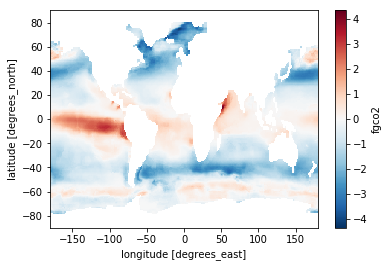

In [4]:
ds.fgco2.mean(dim='time').plot()

In [5]:
area = xr.DataArray(np.empty((len(ds.lat),len(ds.lon))),
                    dims=('lat','lon'),coords=(ds.lat,ds.lon))
area.values = grid_tools.compute_grid_area(ds.lon.values,ds.lat.values)
area

total area = 5.1009974330982400e+14
check area = 5.1009969907076156e+14


<xarray.DataArray (lat: 180, lon: 360)>
array([[1.078939e+08, 1.078925e+08, 1.078939e+08, ..., 1.078939e+08,
        1.078925e+08, 1.078939e+08],
       [3.236818e+08, 3.236774e+08, 3.236818e+08, ..., 3.236818e+08,
        3.236774e+08, 3.236818e+08],
       [5.393853e+08, 5.393779e+08, 5.393853e+08, ..., 5.393853e+08,
        5.393779e+08, 5.393853e+08],
       ...,
       [5.393853e+08, 5.393779e+08, 5.393853e+08, ..., 5.393853e+08,
        5.393779e+08, 5.393853e+08],
       [3.236818e+08, 3.236774e+08, 3.236818e+08, ..., 3.236818e+08,
        3.236774e+08, 3.236818e+08],
       [1.078939e+08, 1.078925e+08, 1.078939e+08, ..., 1.078939e+08,
        1.078925e+08, 1.078939e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...

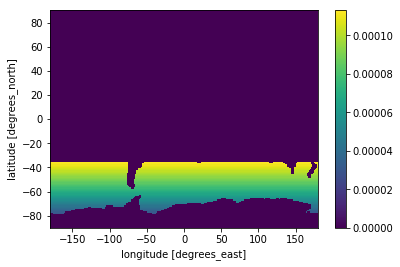

In [28]:
rmask = ds.seamask * area.where(ds.lat<-35.).fillna(0.)
total_area = rmask.sum()
rmask = rmask / total_area
np.testing.assert_approx_equal(rmask.sum(),1.)
rmask.plot()

In [29]:
dpm = xr.DataArray(xcal.get_dpm(ds.time.to_index()),coords=[ds.time])
wgt = dpm.groupby('time.year') / dpm.groupby('time.year').sum()
nyr = len(np.unique(wgt.year))

np.testing.assert_almost_equal(wgt.groupby('time.year').sum(), np.ones(nyr))
wgt

<xarray.DataArray (time: 432)>
array([0.084932, 0.076712, 0.084932, ..., 0.084932, 0.082192, 0.084932])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
    year     (time) int64 1982 1982 1982 1982 1982 1982 1982 1982 1982 1982 ...

In [30]:
molC_to_PgC = 12e-15
so = (ds * rmask).sum(dim=('lat','lon'))
for v in so.variables:
    if 'fgco2' in v:
        so[v] = so[v] * total_area * molC_to_PgC
        so[v].attrs['units'] = 'Pg C'
so

<xarray.Dataset>
Dimensions:         (bnds: 2, time: 432)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
Dimensions without coordinates: bnds
Data variables:
    spco2           (time) float64 318.3 319.6 323.0 324.7 320.2 319.4 311.5 ...
    fgco2           (time) float64 -0.7485 -0.7544 -0.531 -0.3612 -0.5653 ...
    spco2_smoothed  (time) float64 319.0 320.3 322.6 324.2 325.2 321.6 320.5 ...
    fgco2_smoothed  (time) float64 -0.7026 -0.7241 -0.5485 -0.4944 -0.47 ...
    seamask         float64 1.0
    time_bnds       (time, bnds) float64 -5.681e+08 -5.654e+08 -5.654e+08 ...
    lat_bnds        (bnds) float64 -51.16 -50.16
    lon_bnds        (bnds) float64 -6.222 -5.222

In [31]:
soann = (so * wgt).groupby('time.year').sum(dim='time')
sostd = (so * wgt).groupby('time.year').std(dim='time')
soann

<xarray.Dataset>
Dimensions:         (bnds: 2, year: 36)
Coordinates:
  * year            (year) int64 1982 1983 1984 1985 1986 1987 1988 1989 ...
Dimensions without coordinates: bnds
Data variables:
    spco2           (year) float64 320.0 321.4 322.6 323.9 325.1 326.1 327.4 ...
    fgco2           (year) float64 -0.64 -0.6766 -0.7492 -0.7111 -0.7537 ...
    spco2_smoothed  (year) float64 322.6 324.1 325.3 326.6 327.9 328.9 330.2 ...
    fgco2_smoothed  (year) float64 -0.6421 -0.6782 -0.7519 -0.715 -0.7497 ...
    seamask         (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    time_bnds       (year, bnds) float64 -5.536e+08 -5.51e+08 -5.221e+08 ...
    lat_bnds        (year, bnds) float64 -51.16 -50.16 -51.16 -50.16 -51.16 ...
    lon_bnds        (year, bnds) float64 -6.222 -5.222 -6.222 -5.222 -6.222 ...

In [32]:
file_in = '/glade/work/mclong/pco2-landschutzer/spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc'
dsc = xr.open_dataset(file_in,drop_variables='date') # xarray gets hung up on the date var: omit
dsc

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 180, lon: 360, monthclim: 12)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: bnds, monthclim
Data variables:
    spco2_clim  (monthclim, lat, lon) float32 ...
    fgco2_clim  (monthclim, lat, lon) float32 ...
    lat_bnds    (lat, bnds) float32 ...
    lon_bnds    (lon, bnds) float32 ...
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2016_clim
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2017-06-22
    history:        Wed Jan 10 17:15:45 2018: ncrename -a .FillValue.,_FillVa...
    NCO:            4.6.9

In [33]:
xr.concat([dsc.rename({'monthclim':'time'}) for i in range(36)],dim='time')

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 180, lon: 360, time: 432)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: bnds, time
Data variables:
    spco2_clim  (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    fgco2_clim  (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    lat_bnds    (time, lat, bnds) float32 -90.0 -89.0 -89.0 -88.0 -88.0 ...
    lon_bnds    (time, lon, bnds) float32 -180.0 -179.0 -179.0 -178.0 -178.0 ...
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2016_clim
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2017-06-22
    history:        Wed Jan 10 17:15:45 2018: ncrename -a .FillValue.,_FillVa...
    NCO:            4

In [34]:
dsc_r = xr.Dataset({'time':ds.time,
                    'fgco2_clim':xr.concat([dsc.fgco2_clim.rename({'monthclim':'time'}) for i in range(36)],dim='time')})
so_clim = (dsc_r * rmask).sum(dim=('lat','lon'))
so_clim

<xarray.Dataset>
Dimensions:     (time: 432)
Coordinates:
  * time        (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
Data variables:
    fgco2_clim  (time) float64 -0.9338 -0.9162 -0.8763 -0.8551 -0.8184 ...

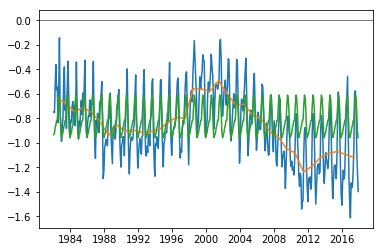

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(so.time,so.fgco2)
ax.plot([datetime(y,7,1) for y in soann.year],soann.fgco2)
ax.plot(so_clim.time,so_clim.fgco2_clim)

ax.axhline(0.,linewidth=0.5,color='k')